# Evaluate a Network

In [1]:
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, GlobalAveragePooling2D, Dense
import tensorflow as tf
from keras import Sequential, Model
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.utils import split_dataset
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style("whitegrid")

In [2]:
# To avoid: 
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized. 
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Split the image dataset into three separate datasets for training, validation and testing.

In [3]:
train_dataset, remaining_dataset = image_dataset_from_directory("../data/Animals/", 
                                                                validation_split=0.2,
                                                                subset='both',
                                                                seed=0,
                                                                image_size=(224, 224))

validation_dataset, test_dataset = split_dataset(remaining_dataset, left_size=0.75)
class_names = train_dataset.class_names

Found 442 files belonging to 3 classes.
Using 354 files for training.
Using 88 files for validation.


Show the first nine images and labels from the training set.

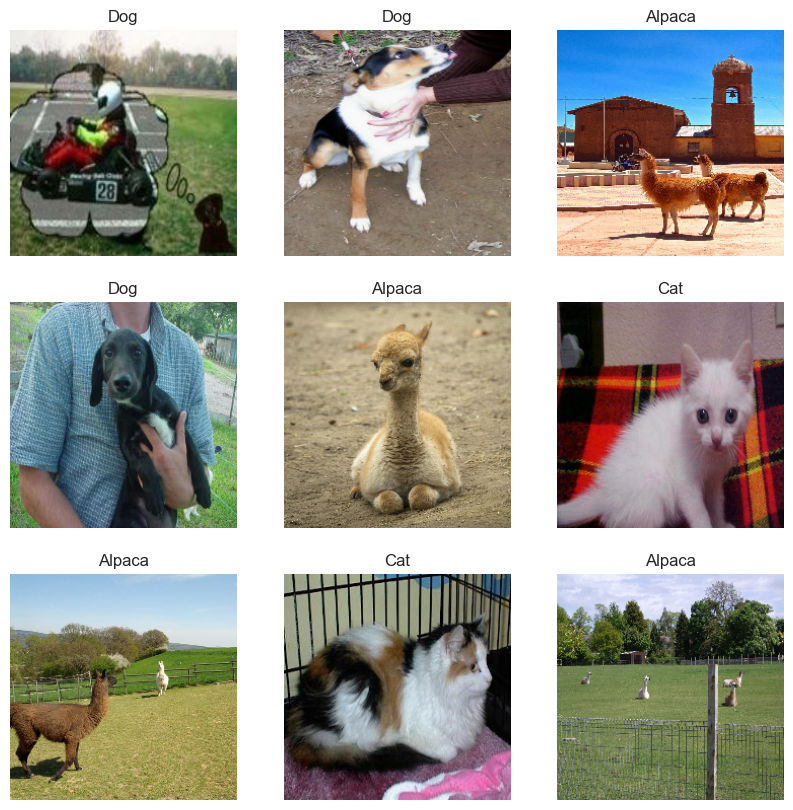

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). We can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [6]:
data_augmentation = Sequential([tf.keras.layers.RandomFlip('horizontal'),
                                tf.keras.layers.RandomRotation(0.2)])

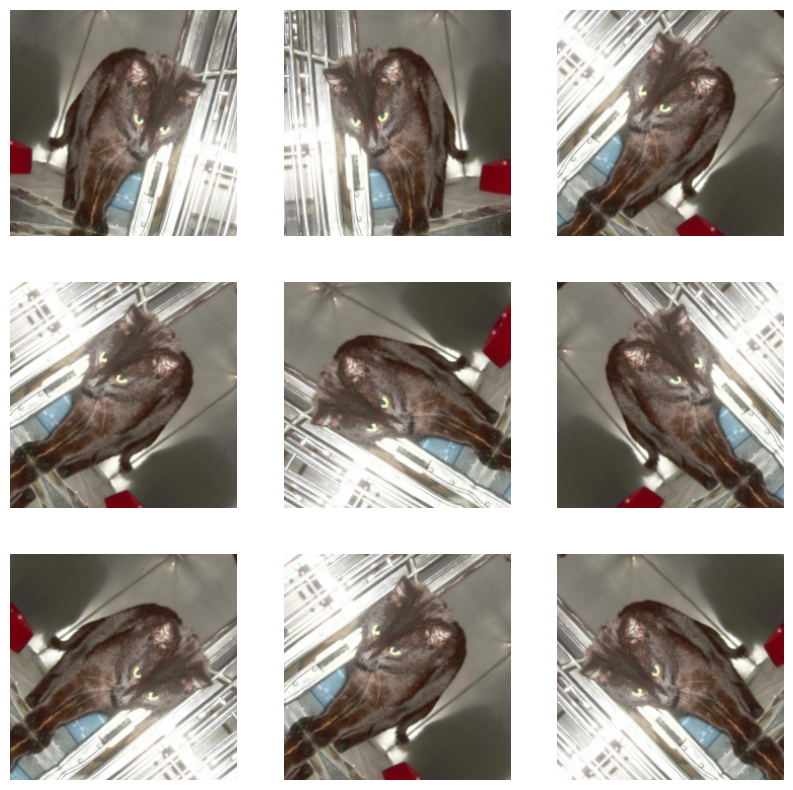

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Create the base model from the pre-trained convnets

The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a Inception V3 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

In [8]:
# Create the base model from the pre-trained model Inception V3
base_model = InceptionV3(input_tensor=Input(shape=(224, 224, 3)), 
                         weights='imagenet', 
                         include_top=False)

This feature extractor converts each 224x224x3 image into a 5x5x2048 block of features. Let's see what it does to an example batch of images:

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


## Freeze the convolutional base

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. Inception V3 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [10]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

## Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a [tf.keras.layers.GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 2048-element vector per image.

In [11]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to convert these features into three prediction per image. We need an activation function "softmax" to get the prediction probabilities for each class.

In [12]:
prediction_layer = Dense(units=3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, we use training=False as our model contains a BatchNormalization layer.

In [13]:
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

## Compile the model

Compile the model before training it. Since there are three classes, we use the [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss.

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

The 21 million parameters in MobileNet are frozen, but there are 6 thousand trainable parameters in the Dense layer.

## Train the model

In [16]:
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20


12/12 [==============================] - 22s 1s/step - loss: 1.1225 - accuracy: 0.4266 - val_loss: 0.8891 - val_accuracy: 0.5909
Epoch 2/20
12/12 [==============================] - 12s 936ms/step - loss: 0.9420 - accuracy: 0.5678 - val_loss: 0.7320 - val_accuracy: 0.7121
Epoch 3/20
12/12 [==============================] - 12s 968ms/step - loss: 0.7582 - accuracy: 0.7401 - val_loss: 0.6171 - val_accuracy: 0.8030
Epoch 4/20
12/12 [==============================] - 12s 1s/step - loss: 0.6818 - accuracy: 0.7458 - val_loss: 0.5403 - val_accuracy: 0.8333
Epoch 5/20
12/12 [==============================] - 12s 952ms/step - loss: 0.6115 - accuracy: 0.7797 - val_loss: 0.4827 - val_accuracy: 0.8485
Epoch 6/20
12/12 [==============================] - 12s 966ms/step - loss: 0.5408 - accuracy: 0.8192 - val_loss: 0.4218 - val_accuracy: 0.8788
Epoch 7/20
12/12 [==============================] - 12s 990ms/step - loss: 0.4851 - accuracy: 0.8757 - val_loss: 0.3813 - val_accuracy: 0.8939
Epoch 8/20
12/12

## Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the Inception V3 base model as a fixed feature extractor.

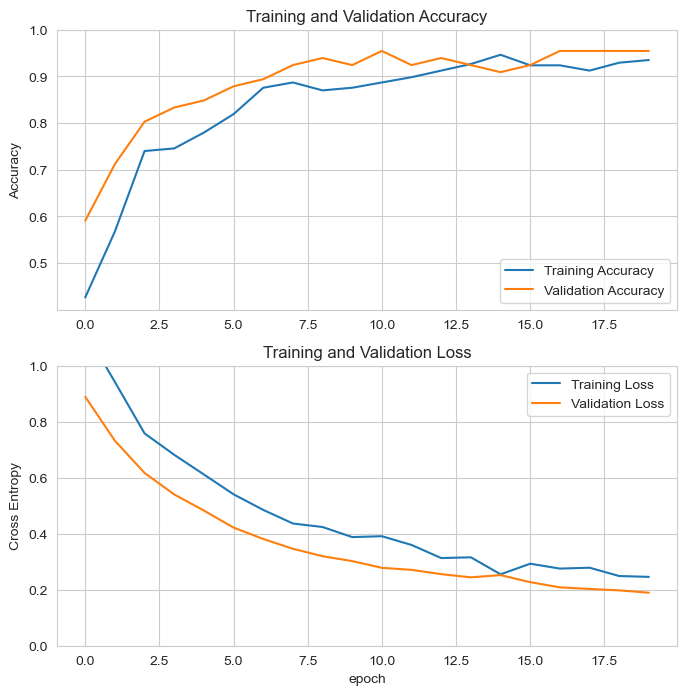

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Calculate the testing accuracy by comparing the labels in the test image datastore with the predicted labels from the network.

In [18]:
y_test = np.concatenate([y for _, y in test_dataset], axis=0)

y_pred = []
for i in model.predict(test_dataset, verbose=False):
    y_pred.append(i.argmax())

test_loss, test_accuracy = model.evaluate(test_dataset, verbose=False)

print("Test loss =", test_loss)
print("Test accuracy =", test_accuracy)#

Test loss = 0.23317976295948029
Test accuracy = 0.9090909361839294


The confusion matrix shows which labels were misclassified.

<Figure size 640x480 with 0 Axes>

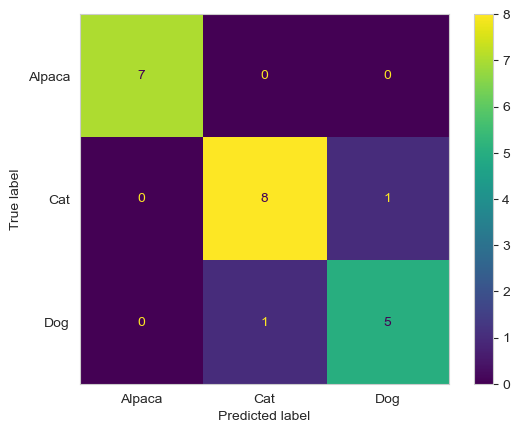

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot()
plt.grid(False)
plt.show()